<a href="https://colab.research.google.com/github/shani1610/feature-matching-experiments/blob/main/Feature_Matching_Expiriments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Matching Expiriments

i am using the scenarious from https://www.kaggle.com/competitions/image-matching-challenge-2024/overview ,
the data they procided is for 3D reconstruction,
but it this notebook i will use pairs of images for the feature matching task only.

the authors designated 6 categories, each with its distinct challenge:

Phototourism and historical preservation: different viewpoints, sensor types, time of day/year, and occlusions. Ancient historical sites add a unique set of challenges

Night vs day and temporal changes: combination of day and night photographs, including poor lighting, or photographs taken months or years apart, in different weather

Aerial and mixed aerial-ground: images from drones, featuring arbitrary in-plane rotations, matched against similar images and also images taken from the ground

Repeated structures: symmetrical objects require details to disambiguate perspective

Natural environments: highly non-regular structures such as trees and foliage

Transparencies and reflections: objects like glassware are lacking in texture and create reflections and specularities which pose a different set of problems

i will use these pairs to compare the SIFT and LoFTR approaches for feature matching.


# Load the Images

In [1]:
# Step 1: Download the file
!wget -O image_pairs.zip "https://www.dropbox.com/scl/fi/alf379m2t50is6n1q4rpq/image_pairs.zip?rlkey=hbo7skh23vivwyviz8uwtm1f6&dl=1"

# Step 2: Create a directory and unzip the file there
!mkdir -p image_pairs
!unzip -q image_pairs.zip -d image_pairs

# Step 3: Verify the extracted files
!ls image_pairs

--2025-02-07 10:58:24--  https://www.dropbox.com/scl/fi/alf379m2t50is6n1q4rpq/image_pairs.zip?rlkey=hbo7skh23vivwyviz8uwtm1f6&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9df1d0bfbe9f6c0991e3b1294a.dl.dropboxusercontent.com/cd/0/inline/CjrCjhgTXioA_mryvrZA26sb-BJfJsnxE4cXRCV6nTQ7P3KHi4Z3nKXC-b7KTT3iEQWx7LIKtDyvr1e1yyaEPaNqh-zPSqbWpSpZIzZM0dHg0UkN4stWtz3Bghg1cqa3YZYQMI_dsCMG1S-u_SKdmu_T/file?dl=1# [following]
--2025-02-07 10:58:25--  https://uc9df1d0bfbe9f6c0991e3b1294a.dl.dropboxusercontent.com/cd/0/inline/CjrCjhgTXioA_mryvrZA26sb-BJfJsnxE4cXRCV6nTQ7P3KHi4Z3nKXC-b7KTT3iEQWx7LIKtDyvr1e1yyaEPaNqh-zPSqbWpSpZIzZM0dHg0UkN4stWtz3Bghg1cqa3YZYQMI_dsCMG1S-u_SKdmu_T/file?dl=1
Resolving uc9df1d0bfbe9f6c0991e3b1294a.dl.dropboxusercontent.com (uc9df1d0bfbe9f6c0991e3b1294a.dl.dropboxusercontent.com)...

In [ ]:
# Step 1: Download the file
!wget -O image_pairs.zip "https://www.dropbox.com/scl/fi/alf379m2t50is6n1q4rpq/image_pairs.zip?rlkey=hbo7skh23vivwyviz8uwtm1f6&dl=1"

# Step 2: Extract directly into the current directory
!unzip -q image_pairs.zip

# Step 3: Move files up if there's a nested folder
import os
import shutil

# Define paths
extracted_folder = "image_pairs"
target_folder = "."

# Check if the extracted folder contains another "image_pairs" inside it
inner_folder = os.path.join(extracted_folder, extracted_folder)
if os.path.exists(inner_folder):
    for file in os.listdir(inner_folder):
        shutil.move(os.path.join(inner_folder, file), extracted_folder)  # Move files up
    os.rmdir(inner_folder)  # Remove the empty nested folder

# Step 4: Verify final structure
!ls image_pairs

In [ ]:
img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]

# SIFT

# LoFTR demo with custom image pairs on Colab
We provide an easier way to run LoFTR with a custom image pair without configuring a python environment with GPU support. Signing in your Google account is required to run this notebook in Colab.

Start by clicking Runtime --> Run all (Ctrl/Cmd + F9).

Upload your own image pair with the "Choose Files" button to appear in the first cell. Please use horizontal images (width > height) and assign the image type (indoor/outdoor) accordingly.

You can also choose to use the example image pair provided in the LoFTR repo (from ScanNet) by using this cell (uncommenting the last line).


In [ ]:
image_type = 'outdoor'

In [ ]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights
%cd weights/
#!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ..

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

In [ ]:
# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cuda()

<ipython-input-6-011ecbd77aeb>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])


In [ ]:
# Rerun this cell (and below) if a new image pair is uploaded.
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

In [ ]:


img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

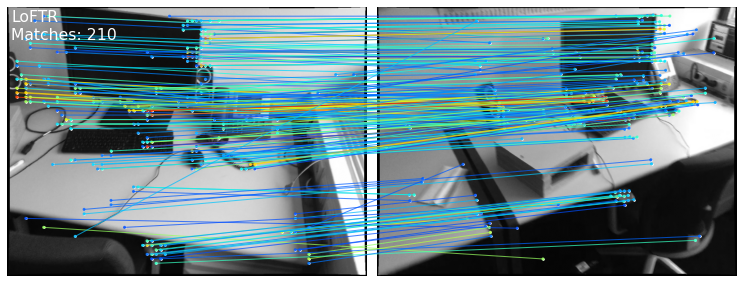

In [ ]:
# Draw
color = cm.jet(mconf, alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)

# A high-res PDF will also be downloaded automatically.
make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo.pdf")
# files.download("LoFTR-colab-demo.pdf")